In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn import model_selection
from sklearn.metrics import accuracy_score
import xgboost as xgb
import warnings
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
warnings.filterwarnings('ignore')

In [2]:
sys.path

['C:\\Users\\camer\\OneDrive\\Documents\\dev\\home_research\\research_projects',
 'C:\\Users\\camer\\anaconda3\\envs\\home_research\\python310.zip',
 'C:\\Users\\camer\\anaconda3\\envs\\home_research\\DLLs',
 'C:\\Users\\camer\\anaconda3\\envs\\home_research\\lib',
 'C:\\Users\\camer\\anaconda3\\envs\\home_research',
 '',
 'C:\\Users\\camer\\anaconda3\\envs\\home_research\\lib\\site-packages',
 'C:\\Users\\camer\\anaconda3\\envs\\home_research\\lib\\site-packages\\win32',
 'C:\\Users\\camer\\anaconda3\\envs\\home_research\\lib\\site-packages\\win32\\lib',
 'C:\\Users\\camer\\anaconda3\\envs\\home_research\\lib\\site-packages\\Pythonwin',
 'C:\\Users\\camer\\anaconda3\\envs\\home_research\\lib\\site-packages\\setuptools\\_vendor',
 '..']

## Read Train data

In [3]:
path = 'C:/Users/camer/OneDrive/Documents/dev/home_research/data/football_prediction/'

train_home_team_statistics_df = pd.read_csv(path + 'train_home_team_statistics_df.csv', index_col=0)
train_away_team_statistics_df = pd.read_csv(path + 'train_away_team_statistics_df.csv', index_col=0)

train_scores = pd.read_csv(path + 'Y_train.csv', index_col=0)

train_team_home = train_home_team_statistics_df.iloc[:,2:]
train_team_away = train_away_team_statistics_df.iloc[:,2:]

train_team_home.columns = 'HOME_' + train_team_home.columns
train_team_away.columns = 'AWAY_' + train_team_away.columns

train_team_data =  pd.concat([train_team_home,train_team_away],join='inner',axis=1)
train_team_scores = train_scores.loc[train_team_home.index]


In [4]:
train_team_home.head()

,HOME_TEAM_SHOTS_TOTAL_season_sum,HOME_TEAM_SHOTS_INSIDEBOX_season_sum,HOME_TEAM_SHOTS_OFF_TARGET_season_sum,HOME_TEAM_SHOTS_ON_TARGET_season_sum,HOME_TEAM_SHOTS_OUTSIDEBOX_season_sum,HOME_TEAM_PASSES_season_sum,HOME_TEAM_SUCCESSFUL_PASSES_season_sum,HOME_TEAM_SAVES_season_sum,HOME_TEAM_CORNERS_season_sum,HOME_TEAM_FOULS_season_sum,...,HOME_TEAM_YELLOWCARDS_5_last_match_std,HOME_TEAM_REDCARDS_5_last_match_std,HOME_TEAM_OFFSIDES_5_last_match_std,HOME_TEAM_ATTACKS_5_last_match_std,HOME_TEAM_PENALTIES_5_last_match_std,HOME_TEAM_SUBSTITUTIONS_5_last_match_std,HOME_TEAM_BALL_SAFE_5_last_match_std,HOME_TEAM_DANGEROUS_ATTACKS_5_last_match_std,HOME_TEAM_INJURIES_5_last_match_std,HOME_TEAM_GOALS_5_last_match_std
ID,,,,,,,,,,,,,,,,,,,,,
0,3.0,2.0,5.0,2.0,1.0,2.0,2.0,5.0,3.0,6.0,...,3.0,0.0,6.0,0.0,10.0,8.0,7.0,2.0,4.0,3.0
1,6.0,8.0,3.0,6.0,5.0,8.0,7.0,10.0,6.0,8.0,...,4.0,0.0,4.0,3.0,10.0,0.0,1.0,2.0,8.0,4.0
2,4.0,2.0,5.0,2.0,8.0,1.0,1.0,2.0,2.0,7.0,...,4.0,5.0,6.0,3.0,6.0,7.0,2.0,3.0,2.0,4.0
3,7.0,5.0,5.0,6.0,6.0,9.0,9.0,2.0,2.0,0.0,...,4.0,0.0,1.0,8.0,8.0,5.0,5.0,5.0,NaN,6.0
4,3.0,3.0,2.0,3.0,4.0,4.0,3.0,4.0,4.0,7.0,...,1.0,0.0,2.0,5.0,8.0,7.0,2.0,6.0,4.0,4.0


In [5]:
train_scores.sum()

HOME_WINS    5356
DRAW         3186
AWAY_WINS    3761
dtype: int64

In [6]:
train_home_player_statistics_df = pd.read_csv(path + 'train_home_player_statistics_df.csv', index_col=0)
train_away_player_statistics_df = pd.read_csv(path + 'train_away_player_statistics_df.csv', index_col=0)

In [7]:
train_player_home = train_home_player_statistics_df.iloc[:,2:]
train_player_away = train_away_player_statistics_df.iloc[:,2:]

## Feature Engineering

In [8]:
defensive_traits = ['PLAYER_CLEARANCES', 'PLAYER_ERROR_LEAD_TO_GOAL', 'PLAYER_SHOTS_BLOCKED', 'PLAYER_INTERCEPTIONS', 'PLAYER_DRIBBLED_PAST']
midfield_traits = ['PLAYER_ACCURATE_PASSES', 'PLAYER_DISPOSSESSED', 'PLAYER_DUELS_LOST', 'PLAYER_DUELS_WON', 'PLAYER_ASSISTS', 'PLAYER_BIG_CHANCES_CREATED']
attack_traits = ['PLAYER_HIT_WOODWORK', 'PLAYER_SHOTS_ON_TARGET', 'PLAYER_ASSISTS', 'PLAYER_BIG_CHANCES_CREATED', 'PLAYER_BIG_CHANCES_MISSED', 'PLAYER_GOALS']

#### Some potential feature engineering ideas:
- (last 5 - mean) / std
- diffs between home and away (mean and sum, dont do for std)
- total std of 2 teams (could be an indicator of a draw due to inconsistency)
- count of attackers, midfielders, defenders on each team - given num on starting lineup
(al the below for players on average starting lineup)
- goalkeepers shots saved, punched, goals conceded, long balls
- defenders sum of clearences, error lead to goal, shots blocked, interceptions, dribbled past
- midfielders key passes, interceptions, assists, duals won/total duals, aerials won
- forwards goals, big hances missed - big chances created, assists

In [9]:
initial_features = pd.DataFrame(index=train_team_data.index)
# lets just get the core feature names here 
suffixes = ['_season_sum', '_season_average', '_season_std', '_5_last_match_sum', '_5_last_match_average', '_5_last_match_std']
features_no_suffix = []
for suffix in suffixes:
    for feature in train_home_team_statistics_df.columns[2:]:
        if suffix in feature:
            feature_no_suffix = feature.replace(suffix, '')
            if feature_no_suffix not in features_no_suffix:
                features_no_suffix.append(feature_no_suffix)
                print('added from ' + suffix)
features_no_suffix

added from _season_sum
added from _season_sum
added from _season_sum
added from _season_sum
added from _season_sum
added from _season_sum
added from _season_sum
added from _season_sum
added from _season_sum
added from _season_sum
added from _season_sum
added from _season_sum
added from _season_sum
added from _season_sum
added from _season_sum
added from _season_sum
added from _season_sum
added from _season_sum
added from _season_sum
added from _season_sum
added from _season_sum
added from _season_sum
added from _season_sum
added from _season_average
added from _season_average


['TEAM_SHOTS_TOTAL',
 'TEAM_SHOTS_INSIDEBOX',
 'TEAM_SHOTS_OFF_TARGET',
 'TEAM_SHOTS_ON_TARGET',
 'TEAM_SHOTS_OUTSIDEBOX',
 'TEAM_PASSES',
 'TEAM_SUCCESSFUL_PASSES',
 'TEAM_SAVES',
 'TEAM_CORNERS',
 'TEAM_FOULS',
 'TEAM_YELLOWCARDS',
 'TEAM_REDCARDS',
 'TEAM_OFFSIDES',
 'TEAM_ATTACKS',
 'TEAM_PENALTIES',
 'TEAM_SUBSTITUTIONS',
 'TEAM_BALL_SAFE',
 'TEAM_DANGEROUS_ATTACKS',
 'TEAM_INJURIES',
 'TEAM_GOALS',
 'TEAM_GAME_WON',
 'TEAM_GAME_DRAW',
 'TEAM_GAME_LOST',
 'TEAM_SUCCESSFUL_PASSES_PERCENTAGE',
 'TEAM_BALL_POSSESSION']

In [10]:
features_with_std = features_no_suffix[:-5]
for feature in features_with_std:
    initial_features['HOME_' + feature + '_tstat'] = (train_team_data['HOME_' + feature + '_5_last_match_average'] - train_team_data['HOME_' + feature + '_season_average'])/train_team_data['HOME_' + feature + '_season_std']
    initial_features['AWAY_' + feature + '_tstat'] = (train_team_data['AWAY_' + feature + '_5_last_match_average'] - train_team_data['AWAY_' + feature + '_season_average'])/train_team_data['AWAY_' + feature + '_season_std']
    initial_features['HOME_' + feature + '_std_ratio'] = train_team_data['HOME_' + feature + '_5_last_match_std']/train_team_data['HOME_' + feature + '_season_std']
    initial_features['AWAY_' + feature + '_std_ratio'] = train_team_data['AWAY_' + feature + '_5_last_match_std']/train_team_data['AWAY_' + feature + '_season_std']
    initial_features[feature + '_var_sum_season'] = np.sqrt(train_team_data['HOME_' + feature + '_season_std']**2 + train_team_data['AWAY_' + feature + '_season_std']**2)
    initial_features[feature + '_var_sum_last_5_games'] = np.sqrt(train_team_data['HOME_' + feature + '_5_last_match_std']**2 + train_team_data['AWAY_' + feature + '_5_last_match_std']**2)

initial_features

,HOME_TEAM_SHOTS_TOTAL_tstat,AWAY_TEAM_SHOTS_TOTAL_tstat,HOME_TEAM_SHOTS_TOTAL_std_ratio,AWAY_TEAM_SHOTS_TOTAL_std_ratio,TEAM_SHOTS_TOTAL_var_sum_season,TEAM_SHOTS_TOTAL_var_sum_last_5_games,HOME_TEAM_SHOTS_INSIDEBOX_tstat,AWAY_TEAM_SHOTS_INSIDEBOX_tstat,HOME_TEAM_SHOTS_INSIDEBOX_std_ratio,AWAY_TEAM_SHOTS_INSIDEBOX_std_ratio,...,HOME_TEAM_INJURIES_std_ratio,AWAY_TEAM_INJURIES_std_ratio,TEAM_INJURIES_var_sum_season,TEAM_INJURIES_var_sum_last_5_games,HOME_TEAM_GOALS_tstat,AWAY_TEAM_GOALS_tstat,HOME_TEAM_GOALS_std_ratio,AWAY_TEAM_GOALS_std_ratio,TEAM_GOALS_var_sum_season,TEAM_GOALS_var_sum_last_5_games
ID,,,,,,,,,,,,,,,,,,,,,
0,0.200000,-0.500000,0.80,0.00,6.403124,4.000000,0.250000,1.000000,1.000000,3.000000,...,inf,2.00,1.000000,4.472136,1.000000,0.000000,3.000000,0.750000,4.123106,4.242641
1,0.000000,0.000000,1.25,0.80,6.403124,6.403124,-0.333333,NaN,0.666667,NaN,...,2.666667,1.25,5.000000,9.433981,0.100000,0.000000,0.400000,1.500000,10.198039,5.000000
2,0.166667,1.500000,0.50,0.50,6.324555,3.162278,0.333333,0.285714,0.666667,0.714286,...,0.285714,2.25,8.062258,9.219544,0.666667,-1.000000,1.333333,3.000000,3.605551,7.211103
3,-0.800000,1.750000,1.00,1.50,6.403124,7.810250,-0.500000,0.600000,0.875000,0.800000,...,NaN,NaN,NaN,NaN,0.400000,3.000000,1.200000,2.000000,5.099020,6.324555
4,0.200000,0.250000,0.80,1.00,9.433981,8.944272,1.000000,0.200000,3.000000,0.400000,...,1.333333,1.20,5.830952,7.211103,inf,0.100000,inf,0.500000,10.000000,6.403124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12298,-inf,0.333333,NaN,1.00,3.000000,3.000000,NaN,0.000000,NaN,2.000000,...,NaN,NaN,NaN,NaN,0.333333,0.000000,0.666667,0.500000,7.211103,4.472136
12299,0.222222,-0.500000,1.00,0.75,9.848858,9.486833,0.250000,-0.666667,1.000000,0.666667,...,3.000000,3.00,3.605551,10.816654,inf,inf,inf,inf,0.000000,1.414214
12300,-0.500000,-0.500000,1.50,1.50,2.828427,4.242641,0.000000,-0.125000,2.500000,1.125000,...,0.375000,4.00,8.062258,5.000000,-0.250000,-0.333333,0.500000,0.444444,9.848858,4.472136


In [11]:
for feature in features_no_suffix:
    if 'HOME_' + feature + '_5_last_match_sum' in train_team_data.columns:
        initial_features[feature + '_sum_total_season_diff'] = train_team_data['HOME_' + feature + '_season_sum'] - train_team_data['AWAY_' + feature + '_season_sum']
        initial_features[feature + '_sum_last_5_games_diff'] = train_team_data['HOME_' + feature + '_5_last_match_sum'] - train_team_data['AWAY_' + feature + '_5_last_match_sum']
    initial_features[feature + '_avg_total_season_diff'] = train_team_data['HOME_' + feature + '_season_average'] - train_team_data['AWAY_' + feature + '_season_average']
    initial_features[feature + '_sum_last_5_games_diff'] = train_team_data['HOME_' + feature + '_5_last_match_average'] - train_team_data['AWAY_' + feature + '_5_last_match_average']

initial_features

,HOME_TEAM_SHOTS_TOTAL_tstat,AWAY_TEAM_SHOTS_TOTAL_tstat,HOME_TEAM_SHOTS_TOTAL_std_ratio,AWAY_TEAM_SHOTS_TOTAL_std_ratio,TEAM_SHOTS_TOTAL_var_sum_season,TEAM_SHOTS_TOTAL_var_sum_last_5_games,HOME_TEAM_SHOTS_INSIDEBOX_tstat,AWAY_TEAM_SHOTS_INSIDEBOX_tstat,HOME_TEAM_SHOTS_INSIDEBOX_std_ratio,AWAY_TEAM_SHOTS_INSIDEBOX_std_ratio,...,TEAM_GAME_DRAW_sum_total_season_diff,TEAM_GAME_DRAW_sum_last_5_games_diff,TEAM_GAME_DRAW_avg_total_season_diff,TEAM_GAME_LOST_sum_total_season_diff,TEAM_GAME_LOST_sum_last_5_games_diff,TEAM_GAME_LOST_avg_total_season_diff,TEAM_SUCCESSFUL_PASSES_PERCENTAGE_avg_total_season_diff,TEAM_SUCCESSFUL_PASSES_PERCENTAGE_sum_last_5_games_diff,TEAM_BALL_POSSESSION_avg_total_season_diff,TEAM_BALL_POSSESSION_sum_last_5_games_diff
ID,,,,,,,,,,,,,,,,,,,,,
0,0.200000,-0.500000,0.80,0.00,6.403124,4.000000,0.250000,1.000000,1.000000,3.000000,...,-2.0,0.0,-2.0,10.0,5.0,10.0,-3.0,-4.0,-2.0,-3.0
1,0.000000,0.000000,1.25,0.80,6.403124,6.403124,-0.333333,NaN,0.666667,NaN,...,0.0,0.0,0.0,-7.0,-7.0,-6.0,1.0,-1.0,2.0,0.0
2,0.166667,1.500000,0.50,0.50,6.324555,3.162278,0.333333,0.285714,0.666667,0.714286,...,-3.0,-2.0,-3.0,3.0,0.0,2.0,-4.0,-3.0,-5.0,-4.0
3,-0.800000,1.750000,1.00,1.50,6.403124,7.810250,-0.500000,0.600000,0.875000,0.800000,...,5.0,3.0,5.0,-6.0,-7.0,-7.0,4.0,1.0,5.0,2.0
4,0.200000,0.250000,0.80,1.00,9.433981,8.944272,1.000000,0.200000,3.000000,0.400000,...,7.0,3.0,6.0,0.0,0.0,0.0,-1.0,-1.0,-3.0,-3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12298,-inf,0.333333,NaN,1.00,3.000000,3.000000,NaN,0.000000,NaN,2.000000,...,-8.0,-7.0,-8.0,5.0,7.0,5.0,1.0,0.0,-1.0,-5.0
12299,0.222222,-0.500000,1.00,0.75,9.848858,9.486833,0.250000,-0.666667,1.000000,0.666667,...,3.0,0.0,3.0,-2.0,-2.0,-2.0,-5.0,0.0,-1.0,4.0
12300,-0.500000,-0.500000,1.50,1.50,2.828427,4.242641,0.000000,-0.125000,2.500000,1.125000,...,-3.0,-5.0,-3.0,6.0,10.0,6.0,0.0,2.0,-1.0,-3.0


##### Now for players features

In [12]:
def rms(series):
    return np.sqrt(np.mean(series**2))

def create_player_traits_tstat(train_player, traits, non_tstat_traits=[]):
    grouped_player_traits_lst = []
    grouped_player_traits = pd.DataFrame()
    trait_features = pd.DataFrame()
    for suffix in ['_season_average', '_5_last_match_average', '_season_std']:
        grouped_player_traits_suffix = train_player[[trait + suffix for trait in traits]]
        if suffix == '_season_std':
            trait_averages = grouped_player_traits_suffix.groupby('ID').agg(rms)
        else:
            trait_averages = grouped_player_traits_suffix.groupby('ID').mean()
        for trait in non_tstat_traits:
            trait_features[trait + suffix] = trait_averages[trait + suffix]
        grouped_player_traits_lst.append(trait_averages)
    grouped_player_traits = pd.concat(grouped_player_traits_lst, axis=1)
    for trait in set(traits)-set(non_tstat_traits):
        trait_features[trait + '_tstat'] = (grouped_player_traits[trait + '_5_last_match_average'] - grouped_player_traits[trait + '_season_average'])/grouped_player_traits[trait + '_season_std']
    return trait_features

In [13]:

train_player_dict = {'HOME': train_player_home, 'AWAY': train_player_away}
train_player_features = []
for home_away in ['HOME', 'AWAY']:
    train_player = train_player_dict[home_away]

    # counts
    grouped_player_count_by_position = train_player.groupby(['ID', 'POSITION']).count()[['PLAYER_NAME']].rename({'PLAYER_NAME': 'count'}, axis=1)
    df_pivot = grouped_player_count_by_position.pivot_table(
        index='ID',  # The unique identifier
        columns='POSITION',  # Values for which we want separate columns
        values='count',  # The value we want to aggregate (counts)
        aggfunc='sum',  # Aggregation function (sum of counts in this case)
        fill_value=0  # Fill NaN values with 0
    )
    df_pivot.columns = [f'POSITION_{col}_count' for col in df_pivot.columns]
    df_pivot = df_pivot.drop('POSITION_goalkeeper_count', axis=1)
    
    # traits - look at for the specific players in those positions
    defensive_features = create_player_traits_tstat(train_player[train_player['POSITION'] == 'defender'], defensive_traits, ['PLAYER_ERROR_LEAD_TO_GOAL'])
    midfield_features = create_player_traits_tstat(train_player[train_player['POSITION'] == 'midfielder'], midfield_traits, ['PLAYER_BIG_CHANCES_CREATED'])
    attack_features = create_player_traits_tstat(train_player[train_player['POSITION'] == 'attacker'], attack_traits, attack_traits)

    all_team_player_features = pd.concat([df_pivot, defensive_features, midfield_features, attack_features], axis=1)
    all_team_player_features.columns = home_away + '_' + all_team_player_features.columns
    train_player_features.append(all_team_player_features)

train_player_features_df = pd.concat(train_player_features, axis=1)

train_player_features_df

,HOME_POSITION_attacker_count,HOME_POSITION_defender_count,HOME_POSITION_midfielder_count,HOME_PLAYER_ERROR_LEAD_TO_GOAL_season_average,HOME_PLAYER_ERROR_LEAD_TO_GOAL_5_last_match_average,HOME_PLAYER_ERROR_LEAD_TO_GOAL_season_std,HOME_PLAYER_DRIBBLED_PAST_tstat,HOME_PLAYER_INTERCEPTIONS_tstat,HOME_PLAYER_SHOTS_BLOCKED_tstat,HOME_PLAYER_CLEARANCES_tstat,...,AWAY_PLAYER_ASSISTS_5_last_match_average,AWAY_PLAYER_BIG_CHANCES_CREATED_5_last_match_average,AWAY_PLAYER_BIG_CHANCES_MISSED_5_last_match_average,AWAY_PLAYER_GOALS_5_last_match_average,AWAY_PLAYER_HIT_WOODWORK_season_std,AWAY_PLAYER_SHOTS_ON_TARGET_season_std,AWAY_PLAYER_ASSISTS_season_std,AWAY_PLAYER_BIG_CHANCES_CREATED_season_std,AWAY_PLAYER_BIG_CHANCES_MISSED_season_std,AWAY_PLAYER_GOALS_season_std
ID,,,,,,,,,,,,,,,,,,,,,
0,0,6,6,5.50,0.0,28.174457,0.242466,0.122357,0.015323,-0.047539,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,5,8,0.00,0.0,0.000000,-0.017946,-0.079511,-0.045058,-0.168374,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4,7,10,0.00,0.0,0.000000,-0.074639,-0.136903,0.050894,-0.156421,...,6.600000,20.000000,4.000000,13.000000,41.468060,47.038282,42.525287,60.446671,59.299241,43.481030
3,4,4,8,11.75,25.0,31.120733,0.048137,-0.270531,-0.048786,0.054942,...,5.000000,0.000000,12.500000,12.250000,21.000000,39.335099,34.058773,43.926074,28.200177,37.529988
4,4,5,7,6.40,0.0,17.441330,0.154940,0.105516,0.031970,-0.320305,...,25.000000,40.000000,60.000000,0.000000,20.506097,68.764089,48.010416,40.112342,76.853757,74.969994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12298,0,6,7,0.00,0.0,0.000000,0.235132,-0.045268,-0.152119,0.054479,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12299,3,5,8,0.00,0.0,0.000000,-0.355904,-0.160920,-0.387207,0.090959,...,8.333333,13.333333,24.666667,6.666667,42.957343,35.842247,17.897858,29.393877,36.972963,31.299627
12300,0,6,4,0.00,0.0,0.000000,-0.257949,-0.018524,-0.103877,-0.202650,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
train_player_features_df['attacker_diff'] = train_player_features_df['HOME_POSITION_attacker_count'] - train_player_features_df['AWAY_POSITION_attacker_count']
train_player_features_df['midfielder_diff'] = train_player_features_df['HOME_POSITION_midfielder_count'] - train_player_features_df['AWAY_POSITION_midfielder_count']
train_player_features_df['defender_diff'] = train_player_features_df['HOME_POSITION_defender_count'] - train_player_features_df['AWAY_POSITION_defender_count']
train_player_features_df

,HOME_POSITION_attacker_count,HOME_POSITION_defender_count,HOME_POSITION_midfielder_count,HOME_PLAYER_ERROR_LEAD_TO_GOAL_season_average,HOME_PLAYER_ERROR_LEAD_TO_GOAL_5_last_match_average,HOME_PLAYER_ERROR_LEAD_TO_GOAL_season_std,HOME_PLAYER_DRIBBLED_PAST_tstat,HOME_PLAYER_INTERCEPTIONS_tstat,HOME_PLAYER_SHOTS_BLOCKED_tstat,HOME_PLAYER_CLEARANCES_tstat,...,AWAY_PLAYER_GOALS_5_last_match_average,AWAY_PLAYER_HIT_WOODWORK_season_std,AWAY_PLAYER_SHOTS_ON_TARGET_season_std,AWAY_PLAYER_ASSISTS_season_std,AWAY_PLAYER_BIG_CHANCES_CREATED_season_std,AWAY_PLAYER_BIG_CHANCES_MISSED_season_std,AWAY_PLAYER_GOALS_season_std,attacker_diff,midfielder_diff,defender_diff
ID,,,,,,,,,,,,,,,,,,,,,
0,0,6,6,5.50,0.0,28.174457,0.242466,0.122357,0.015323,-0.047539,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1
1,0,5,8,0.00,0.0,0.000000,-0.017946,-0.079511,-0.045058,-0.168374,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2,-2
2,4,7,10,0.00,0.0,0.000000,-0.074639,-0.136903,0.050894,-0.156421,...,13.000000,41.468060,47.038282,42.525287,60.446671,59.299241,43.481030,-1,1,0
3,4,4,8,11.75,25.0,31.120733,0.048137,-0.270531,-0.048786,0.054942,...,12.250000,21.000000,39.335099,34.058773,43.926074,28.200177,37.529988,0,3,-3
4,4,5,7,6.40,0.0,17.441330,0.154940,0.105516,0.031970,-0.320305,...,0.000000,20.506097,68.764089,48.010416,40.112342,76.853757,74.969994,2,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12298,0,6,7,0.00,0.0,0.000000,0.235132,-0.045268,-0.152119,0.054479,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
12299,3,5,8,0.00,0.0,0.000000,-0.355904,-0.160920,-0.387207,0.090959,...,6.666667,42.957343,35.842247,17.897858,29.393877,36.972963,31.299627,0,0,0
12300,0,6,4,0.00,0.0,0.000000,-0.257949,-0.018524,-0.103877,-0.202650,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,-2,0


In [44]:
# look at key players (players where over 70% of matches they have played, they have won)
# WE CAN'T USE THIS, WE DON'T HAVE PLAYER NAMES IN THE TEST SET!
'''
train_home = train_player_dict['HOME']
player_win_ratios_home = train_home.join(train_scores[['HOME_WINS']])[['PLAYER_NAME', 'HOME_WINS']].groupby('PLAYER_NAME').mean()
player_minutes_played_home = set(train_home[train_home['PLAYER_MINUTES_PLAYED_season_average'] > 45]['PLAYER_NAME'])
train_away = train_player_dict['AWAY']
player_win_ratios_away = train_away.join(train_scores[['AWAY_WINS']])[['PLAYER_NAME', 'AWAY_WINS']].groupby('PLAYER_NAME').mean()
player_minutes_played_away = set(train_away[train_away['PLAYER_MINUTES_PLAYED_season_average'] > 45]['PLAYER_NAME'])
eligible_players = player_minutes_played_home.union(player_minutes_played_away)
player_wins = player_win_ratios_home.join(player_win_ratios_away)
key_home_players = player_wins[player_wins['HOME_WINS'] > 0.7].index
key_away_players = player_wins[player_wins['AWAY_WINS'] > 0.7].index
train_home['key_home_player'] = train_home['PLAYER_NAME'].isin(set(key_home_players).intersection(eligible_players))
train_home['key_away_player'] = train_home['PLAYER_NAME'].isin(set(key_away_players).intersection(eligible_players))
key_players_features = train_home[['key_home_player']].groupby('ID').sum().rename({'key_home_player': 'key_home_players'}, axis=1)
key_players_features['key_away_players'] = train_home[['key_away_player']].groupby('ID').sum()
'''

In [15]:
all_train_features = pd.concat([initial_features, train_player_features_df], axis=1)
all_train_features

,HOME_TEAM_SHOTS_TOTAL_tstat,AWAY_TEAM_SHOTS_TOTAL_tstat,HOME_TEAM_SHOTS_TOTAL_std_ratio,AWAY_TEAM_SHOTS_TOTAL_std_ratio,TEAM_SHOTS_TOTAL_var_sum_season,TEAM_SHOTS_TOTAL_var_sum_last_5_games,HOME_TEAM_SHOTS_INSIDEBOX_tstat,AWAY_TEAM_SHOTS_INSIDEBOX_tstat,HOME_TEAM_SHOTS_INSIDEBOX_std_ratio,AWAY_TEAM_SHOTS_INSIDEBOX_std_ratio,...,AWAY_PLAYER_GOALS_5_last_match_average,AWAY_PLAYER_HIT_WOODWORK_season_std,AWAY_PLAYER_SHOTS_ON_TARGET_season_std,AWAY_PLAYER_ASSISTS_season_std,AWAY_PLAYER_BIG_CHANCES_CREATED_season_std,AWAY_PLAYER_BIG_CHANCES_MISSED_season_std,AWAY_PLAYER_GOALS_season_std,attacker_diff,midfielder_diff,defender_diff
ID,,,,,,,,,,,,,,,,,,,,,
0,0.200000,-0.500000,0.80,0.00,6.403124,4.000000,0.250000,1.000000,1.000000,3.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0
1,0.000000,0.000000,1.25,0.80,6.403124,6.403124,-0.333333,NaN,0.666667,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2.0,-2.0
2,0.166667,1.500000,0.50,0.50,6.324555,3.162278,0.333333,0.285714,0.666667,0.714286,...,13.000000,41.468060,47.038282,42.525287,60.446671,59.299241,43.481030,-1.0,1.0,0.0
3,-0.800000,1.750000,1.00,1.50,6.403124,7.810250,-0.500000,0.600000,0.875000,0.800000,...,12.250000,21.000000,39.335099,34.058773,43.926074,28.200177,37.529988,0.0,3.0,-3.0
4,0.200000,0.250000,0.80,1.00,9.433981,8.944272,1.000000,0.200000,3.000000,0.400000,...,0.000000,20.506097,68.764089,48.010416,40.112342,76.853757,74.969994,2.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12298,-inf,0.333333,NaN,1.00,3.000000,3.000000,NaN,0.000000,NaN,2.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
12299,0.222222,-0.500000,1.00,0.75,9.848858,9.486833,0.250000,-0.666667,1.000000,0.666667,...,6.666667,42.957343,35.842247,17.897858,29.393877,36.972963,31.299627,0.0,0.0,0.0
12300,-0.500000,-0.500000,1.50,1.50,2.828427,4.242641,0.000000,-0.125000,2.500000,1.125000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,-2.0,0.0


In [16]:
all_train_features = all_train_features.replace({np.inf:np.nan,-np.inf:np.nan})
from sklearn.impute import SimpleImputer

threshold = 0.15
# Calculate the percentage of missing values in each column
missing_percent = all_train_features.isnull().mean()
# Drop columns where the percentage of missing values is above the threshold
all_train_features_nan_cut = all_train_features.loc[:, missing_percent < threshold]
print(set(all_train_features.columns) - set(all_train_features_nan_cut))

row_threshold = 0.4
# drop rows where the percentage of missing values is above threshold
max_allowed_nans = int(all_train_features_nan_cut.shape[1] * threshold)
# Drop rows with more than the threshold number of NaNs
all_train_features_nan_cut_rows_cols = all_train_features_nan_cut.dropna(thresh=all_train_features_nan_cut.shape[1] - max_allowed_nans)
print(len(set(all_train_features_nan_cut.index)-set(all_train_features_nan_cut_rows_cols.index)))

{'HOME_TEAM_SUCCESSFUL_PASSES_std_ratio', 'AWAY_TEAM_SUCCESSFUL_PASSES_tstat', 'HOME_PLAYER_HIT_WOODWORK_season_std', 'AWAY_PLAYER_ERROR_LEAD_TO_GOAL_5_last_match_average', 'AWAY_PLAYER_BIG_CHANCES_CREATED_5_last_match_average', 'AWAY_PLAYER_HIT_WOODWORK_season_average', 'HOME_TEAM_BALL_SAFE_tstat', 'AWAY_PLAYER_CLEARANCES_tstat', 'TEAM_INJURIES_sum_total_season_diff', 'AWAY_PLAYER_GOALS_season_average', 'HOME_TEAM_SHOTS_TOTAL_std_ratio', 'AWAY_PLAYER_ASSISTS_season_std', 'HOME_PLAYER_INTERCEPTIONS_tstat', 'HOME_TEAM_OFFSIDES_tstat', 'HOME_PLAYER_GOALS_season_average', 'HOME_PLAYER_BIG_CHANCES_MISSED_5_last_match_average', 'HOME_TEAM_INJURIES_std_ratio', 'AWAY_PLAYER_BIG_CHANCES_CREATED_season_std', 'HOME_TEAM_PASSES_tstat', 'HOME_TEAM_FOULS_std_ratio', 'AWAY_PLAYER_DRIBBLED_PAST_tstat', 'AWAY_PLAYER_HIT_WOODWORK_season_std', 'AWAY_PLAYER_INTERCEPTIONS_tstat', 'HOME_TEAM_SAVES_std_ratio', 'HOME_PLAYER_ERROR_LEAD_TO_GOAL_season_std', 'HOME_PLAYER_SHOTS_ON_TARGET_season_average', 'AWAY_T

## Feature Selection

In [17]:
# use all these functions to assist with feature selection
from helper_functions.general.feature_selection import generate_heatmap, linear_model_with_pvalue_threshold, linear_model_with_anova_f_test, feature_importance_mdi_pmf_with_rf, create_pipeline_with_scaler_and_pca, get_pca_components 

In [19]:
X = all_train_features
scores = train_scores.loc[X.index]

In [21]:
y = scores.idxmax(axis=1).astype('category')
y

ID
0        AWAY_WINS
1             DRAW
2        AWAY_WINS
3        HOME_WINS
4             DRAW
           ...    
12298    AWAY_WINS
12299    AWAY_WINS
12300    AWAY_WINS
12301    HOME_WINS
12302    HOME_WINS
Length: 12303, dtype: category
Categories (3, object): ['AWAY_WINS', 'DRAW', 'HOME_WINS']

In [22]:
# save the engineered features for usage elsewhere
X.to_csv("football_prediction_raw_X.csv")
y.to_csv("football_prediction_y.csv")

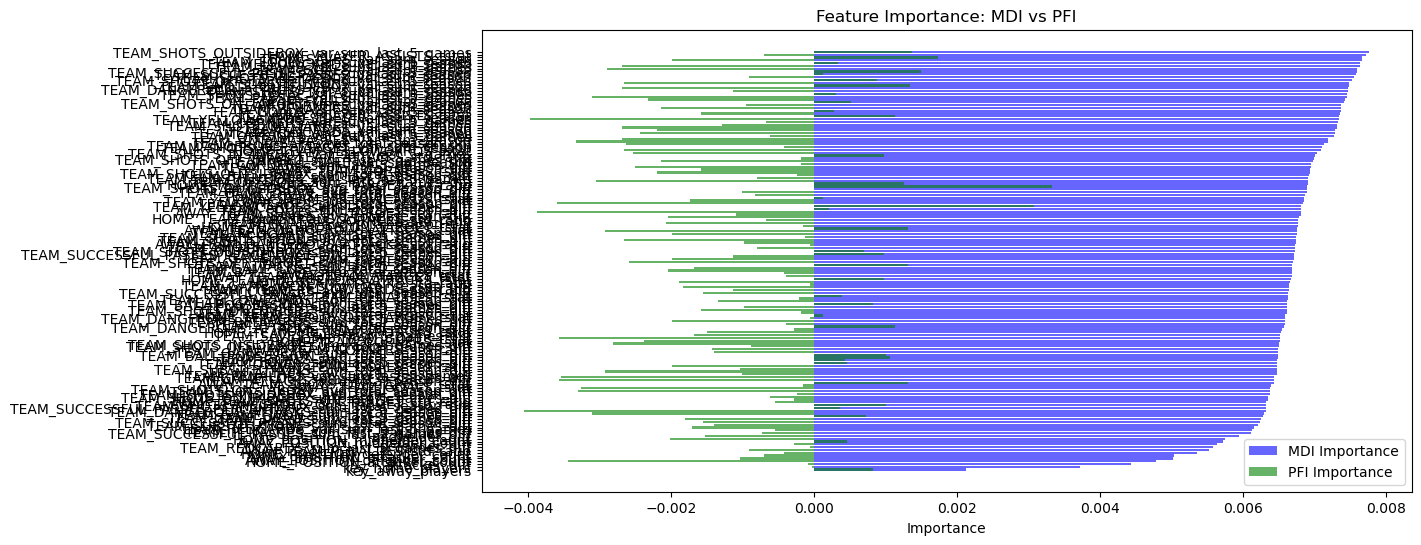

,Feature,MDI Importance,PFI Importance
17,TEAM_SHOTS_OUTSIDEBOX_var_sum_last_5_games,0.007761,0.001372
140,HOME_PLAYER_ASSISTS_tstat,0.007716,-0.000701
22,TEAM_SAVES_var_sum_season,0.007665,0.001738
31,TEAM_FOULS_var_sum_last_5_games,0.007658,-0.001982
36,TEAM_YELLOWCARDS_var_sum_season,0.007634,0.000335
...,...,...,...
142,AWAY_POSITION_defender_count,0.005023,-0.001037
137,HOME_POSITION_attacker_count,0.004784,-0.003446
145,attacker_diff,0.004434,-0.000091
148,key_home_players,0.003723,-0.000030


In [180]:
feature_importance_mdi_pmf_with_rf(X, y, target_type='categorical')

In [120]:
# still nothing clear, lets orthogonalise
pca_and_scaler_pipeline = create_pipeline_with_scaler_and_pca(0.9)
X_tilde = get_pca_components(pca_and_scaler_pipeline, X)

In [121]:
X_tilde = pca_and_scaler_pipeline.fit_transform(X)
X_tilde_df = pd.DataFrame(X_tilde, columns=['PC' + str(i) for i in range(1, X_tilde.shape[1]+1)])
X_tilde_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC61,PC62,PC63,PC64,PC65,PC66,PC67,PC68,PC69,PC70
0,-1.888854,0.424679,-0.163245,-1.790442,-1.715519,0.729038,0.669044,-1.722851,0.529806,-2.671241,...,-1.183560,1.039777,1.080777,0.746639,0.985597,0.920406,-0.832715,-0.145719,1.116579,0.115397
1,4.001962,0.029241,0.010673,4.119763,0.988174,0.345141,0.688788,-2.461338,-0.976192,-1.367646,...,0.324488,-0.792134,0.136043,-0.436603,0.146973,0.560030,0.909190,0.466836,-0.356735,0.274225
2,-2.586249,0.846017,0.089584,1.732369,-2.539607,-0.010884,0.830440,-0.157133,0.471436,-0.442274,...,-0.510369,-0.061652,-0.200170,-0.503255,-0.399458,1.110380,0.784767,0.698553,-0.048874,-1.351088
3,6.200943,-0.129882,0.755125,3.686532,1.499638,0.397687,0.784447,0.959468,1.794609,1.627762,...,0.721814,0.144108,0.763816,-0.948111,-0.442932,1.462296,0.084880,-1.497966,-0.908301,0.371554
4,-4.184105,0.229138,1.570483,-1.604661,1.956802,1.542976,-0.152588,0.208214,0.000626,1.841953,...,0.428839,-0.940916,-1.293156,-0.704122,0.730845,-0.358594,0.280206,0.503497,0.688140,0.685478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10923,-3.929001,-5.931944,1.406286,0.997114,-0.848040,1.277813,-1.141083,-0.901005,-0.406193,-1.372095,...,-1.332084,-0.672197,-1.110998,-0.299748,0.021106,0.044883,0.403348,0.273147,-0.149190,1.672137
10924,-2.906977,-3.254947,-2.497157,0.439325,-2.559370,-1.933147,1.279970,-3.659170,3.145213,-3.798455,...,0.307095,0.686721,-0.477653,1.418213,-0.111681,0.118824,-0.117309,0.496228,-0.616230,-0.470042
10925,-0.920796,3.251148,-1.534504,0.321507,-0.649716,-0.967589,-1.102182,2.698159,-2.338431,2.231874,...,1.670392,0.855411,0.120339,-0.170825,-1.173200,-0.122651,0.421033,-0.040581,0.148045,0.322471
10926,-5.072347,-0.368264,-1.397665,-0.148480,-2.020471,-3.745368,-1.792649,-1.318259,0.669849,2.976125,...,0.338167,0.143385,-0.077842,-0.221675,-0.761844,0.277916,-1.320524,0.621592,-0.065839,0.992859


completed training
obtained MDI feature importances
obtained PFI feature importances


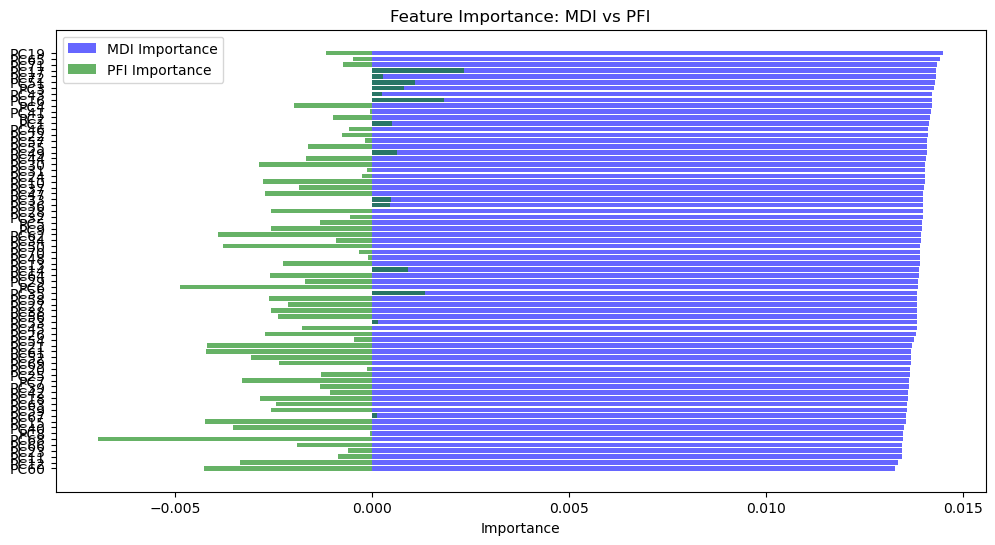

In [52]:
importance_df = feature_importance_mdi_pmf_with_rf(X_tilde_df, y, target_type='categorical')

In [122]:
importance_df.sort_values(by='PFI Importance', ascending=False)

,Feature,MDI Importance,PFI Importance
16,PC17,0.014310,0.002348
15,PC16,0.014211,0.001830
34,PC35,0.013846,0.001342
50,PC51,0.014291,0.001098
13,PC14,0.013897,0.000915
...,...,...,...
60,PC61,0.013692,-0.004209
14,PC15,0.013563,-0.004239
59,PC60,0.013279,-0.004270
5,PC6,0.013869,-0.004880


In [27]:
pca.components_

array([[-1.36255836e-03,  2.02085327e-03,  1.59793704e-04, ...,
         1.75026462e-03,  9.20469621e-02,  6.29145527e-02],
       [-3.69938614e-02, -3.19459905e-02, -3.73538826e-02, ...,
        -9.36252850e-03, -4.11671077e-02, -1.34230659e-02],
       [ 3.04106940e-01,  2.42690379e-01,  2.80075009e-01, ...,
         1.72779497e-03,  1.20781591e-01,  8.37185970e-02],
       ...,
       [ 1.51403242e-01, -2.16727562e-01,  9.17569217e-02, ...,
         5.02393178e-03,  3.21672888e-02, -6.26471260e-02],
       [ 2.22898136e-01, -1.95150202e-01,  1.42661630e-01, ...,
         1.73420958e-02, -4.02245676e-02, -6.65070858e-02],
       [ 5.22902766e-02,  1.55865102e-03,  6.50143032e-03, ...,
         3.21051908e-03, -3.37685234e-02, -2.97739625e-02]])

In [123]:
# how how each component is brokemn down
get_pca_components

<function helper_functions.general.feature_selection.get_pca_components(pipeline, X, feature_names=None)>

## Feature selection was fairly inconclusive, lets just try fitting some models to our principal components

In [124]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

X_train, X_test, y_train, y_test = model_selection.train_test_split(all_train_features_nan_cut_rows_cols, train_scores.loc[all_train_features_nan_cut_rows_cols.index], train_size=0.8, random_state=42)
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent', add_indicator=False)),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.9))
])
pipeline.fit(X_train)
X_train_tilde = pipeline.transform(X_train)
X_test_tilde = pipeline.transform(X_test)

X_train_tilde, X_valid_tilde, y_train, y_valid = model_selection.train_test_split(X_train_tilde, y_train, train_size=0.8, random_state=42)

In [163]:
params_1 = {
    'booster': 'gbtree',
    'tree_method':'hist',
    'max_depth': 8, 
    'learning_rate': 0.025
    }


d_train = xgb.DMatrix(pd.DataFrame(X_train_tilde).replace({0:np.nan}), y_train)
d_valid = xgb.DMatrix(pd.DataFrame(X_valid_tilde).replace({0:np.nan}), y_valid)

num_round = 10000
evallist = [(d_train, 'train'), (d_valid, 'eval')]

bst = xgb.train(params_1, d_train, num_round, evallist, early_stopping_rounds=100)


[0]	train-rmse:0.46842	eval-rmse:0.47036
[1]	train-rmse:0.46548	eval-rmse:0.46941
[2]	train-rmse:0.46254	eval-rmse:0.46850
[3]	train-rmse:0.45959	eval-rmse:0.46759
[4]	train-rmse:0.45672	eval-rmse:0.46673
[5]	train-rmse:0.45394	eval-rmse:0.46609
[6]	train-rmse:0.45109	eval-rmse:0.46537
[7]	train-rmse:0.44868	eval-rmse:0.46468
[8]	train-rmse:0.44596	eval-rmse:0.46404
[9]	train-rmse:0.44352	eval-rmse:0.46347
[10]	train-rmse:0.44121	eval-rmse:0.46295
[11]	train-rmse:0.43897	eval-rmse:0.46248
[12]	train-rmse:0.43670	eval-rmse:0.46189
[13]	train-rmse:0.43450	eval-rmse:0.46142
[14]	train-rmse:0.43218	eval-rmse:0.46096
[15]	train-rmse:0.42996	eval-rmse:0.46052
[16]	train-rmse:0.42805	eval-rmse:0.46018
[17]	train-rmse:0.42609	eval-rmse:0.45988
[18]	train-rmse:0.42414	eval-rmse:0.45957
[19]	train-rmse:0.42209	eval-rmse:0.45924
[20]	train-rmse:0.42030	eval-rmse:0.45899
[21]	train-rmse:0.41838	eval-rmse:0.45884
[22]	train-rmse:0.41645	eval-rmse:0.45856
[23]	train-rmse:0.41457	eval-rmse:0.45832
[2

In [164]:
X_test_xgb = xgb.DMatrix(pd.DataFrame(X_test_tilde))
print(X_train_tilde.shape)
print(X_test_tilde.shape)
predictions = bst.predict(X_test_xgb, iteration_range=(0, bst.best_iteration))
predictions = (pd.DataFrame(predictions).rank(1,ascending=False)==1).astype(int).values
print(predictions)
print(y_test)

np.round(accuracy_score(predictions,y_test),4)

(6993, 70)
(2186, 70)
[[1 0 0]
 [1 0 0]
 [1 0 0]
 ...
 [1 0 0]
 [1 0 0]
 [1 0 0]]
       HOME_WINS  DRAW  AWAY_WINS
ID                               
2216           0     1          0
9342           1     0          0
4397           0     1          0
1925           0     1          0
12245          0     1          0
...          ...   ...        ...
8183           0     1          0
10877          1     0          0
4326           1     0          0
5401           1     0          0
10318          0     0          1

[2186 rows x 3 columns]


0.4913

In [127]:
pd.DataFrame(predictions).value_counts()

0  1  2
1  0  0    1428
0  0  1     655
   1  0     103
Name: count, dtype: int64

## Benchmark

We try to model if AWAY wins

In [9]:
train_new_y = train_scores['AWAY_WINS']

### train, valid test split

In [10]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(train_data, train_new_y, train_size=0.8, random_state=42)
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X_train, y_train, train_size=0.8, random_state=42)


### xgb model

In [11]:
params_1 = {
    'booster': 'gbtree',
    'tree_method':'hist',
    'max_depth': 8, 
    'learning_rate': 0.025,
    'objective': 'multi:softprob',
    'num_class': 2,
    'eval_metric':'mlogloss'
    }


d_train = xgb.DMatrix(X_train.replace({0:np.nan}), y_train)
d_valid = xgb.DMatrix(X_valid.replace({0:np.nan}), y_valid)

num_round = 10000
evallist = [(d_train, 'train'), (d_valid, 'eval')]

bst = xgb.train(params_1, d_train, num_round, evallist, early_stopping_rounds=100)


[0]	train-mlogloss:0.68338	eval-mlogloss:0.68785
[1]	train-mlogloss:0.67389	eval-mlogloss:0.68266
[2]	train-mlogloss:0.66467	eval-mlogloss:0.67757
[3]	train-mlogloss:0.65574	eval-mlogloss:0.67304
[4]	train-mlogloss:0.64724	eval-mlogloss:0.66849
[5]	train-mlogloss:0.63894	eval-mlogloss:0.66438
[6]	train-mlogloss:0.63052	eval-mlogloss:0.66062
[7]	train-mlogloss:0.62230	eval-mlogloss:0.65697
[8]	train-mlogloss:0.61454	eval-mlogloss:0.65359
[9]	train-mlogloss:0.60701	eval-mlogloss:0.65015
[10]	train-mlogloss:0.59949	eval-mlogloss:0.64682
[11]	train-mlogloss:0.59224	eval-mlogloss:0.64347
[12]	train-mlogloss:0.58520	eval-mlogloss:0.64026
[13]	train-mlogloss:0.57876	eval-mlogloss:0.63741
[14]	train-mlogloss:0.57188	eval-mlogloss:0.63467
[15]	train-mlogloss:0.56536	eval-mlogloss:0.63191
[16]	train-mlogloss:0.55888	eval-mlogloss:0.62946
[17]	train-mlogloss:0.55254	eval-mlogloss:0.62681
[18]	train-mlogloss:0.54669	eval-mlogloss:0.62444
[19]	train-mlogloss:0.54078	eval-mlogloss:0.62231
[20]	train

[163]	train-mlogloss:0.19590	eval-mlogloss:0.56893
[164]	train-mlogloss:0.19480	eval-mlogloss:0.56891
[165]	train-mlogloss:0.19338	eval-mlogloss:0.56882
[166]	train-mlogloss:0.19254	eval-mlogloss:0.56889
[167]	train-mlogloss:0.19129	eval-mlogloss:0.56854
[168]	train-mlogloss:0.19041	eval-mlogloss:0.56851
[169]	train-mlogloss:0.18934	eval-mlogloss:0.56867
[170]	train-mlogloss:0.18827	eval-mlogloss:0.56846
[171]	train-mlogloss:0.18683	eval-mlogloss:0.56837
[172]	train-mlogloss:0.18580	eval-mlogloss:0.56860
[173]	train-mlogloss:0.18485	eval-mlogloss:0.56868
[174]	train-mlogloss:0.18373	eval-mlogloss:0.56875
[175]	train-mlogloss:0.18290	eval-mlogloss:0.56876
[176]	train-mlogloss:0.18175	eval-mlogloss:0.56878
[177]	train-mlogloss:0.18071	eval-mlogloss:0.56891
[178]	train-mlogloss:0.17942	eval-mlogloss:0.56898
[179]	train-mlogloss:0.17835	eval-mlogloss:0.56892
[180]	train-mlogloss:0.17758	eval-mlogloss:0.56900
[181]	train-mlogloss:0.17679	eval-mlogloss:0.56899
[182]	train-mlogloss:0.17585	ev

### Some analysis

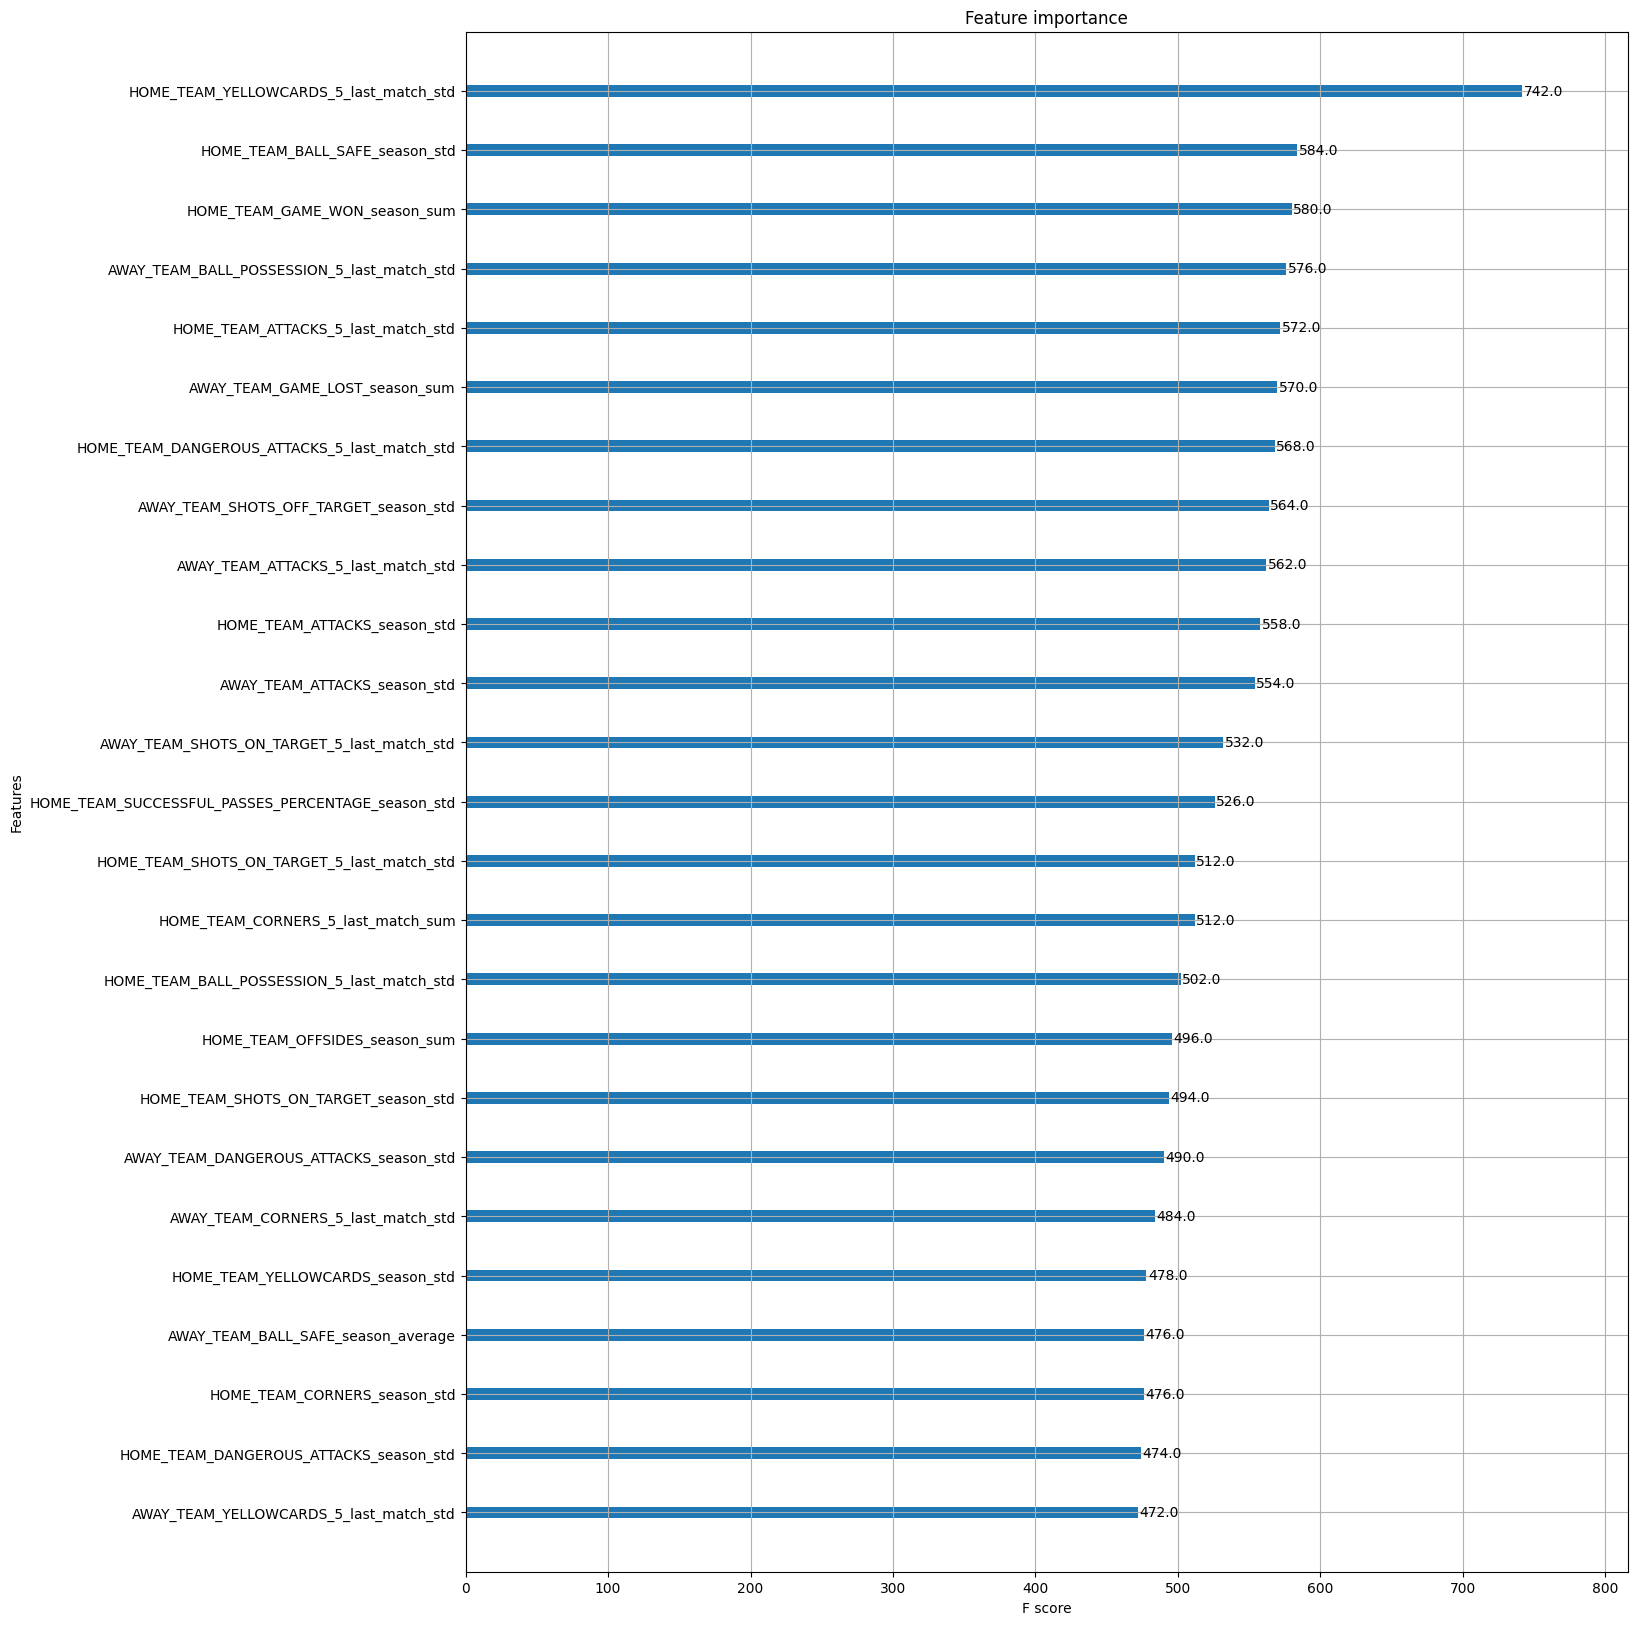

In [12]:
xgb.plot_importance(bst, max_num_features=25)
fig = plt.gcf()
fig.set_size_inches(15, 20)


### Accuracy on test set

A simple benchmark is always predicting home wins

In [13]:
target = train_scores.loc[X_test.index].copy()

home_wins = target
home_wins = 0 * home_wins
home_wins.iloc[:,0] = 1

np.round(accuracy_score(home_wins,target),4)


0.4401

Using our model

In [18]:
X_test_xgb = xgb.DMatrix(X_test)

predictions = bst.predict(X_test_xgb, iteration_range=(0, bst.best_iteration))
predictions = pd.DataFrame(predictions)

predictions[2] = 0
predictions.columns = [0,2,1] # predict no draws, binary classifier just says if home or away team will win
predictions = (predictions.reindex(columns=[0,1,2]).rank(1,ascending=False)==1).astype(int).values
np.round(accuracy_score(predictions,target),4)

0.4742

## Submission

In [128]:

test_home = pd.read_csv(path + 'test_home_team_statistics_df.csv', index_col=0)
test_away = pd.read_csv(path + 'test_away_team_statistics_df.csv', index_col=0)

test_home.columns = 'HOME_' + test_home.columns
test_away.columns = 'AWAY_' + test_away.columns

test_data =  pd.concat([test_home,test_away],join='inner',axis=1)


In [129]:
test_data

,HOME_TEAM_SHOTS_TOTAL_season_sum,HOME_TEAM_SHOTS_INSIDEBOX_season_sum,HOME_TEAM_SHOTS_OFF_TARGET_season_sum,HOME_TEAM_SHOTS_ON_TARGET_season_sum,HOME_TEAM_SHOTS_OUTSIDEBOX_season_sum,HOME_TEAM_PASSES_season_sum,HOME_TEAM_SUCCESSFUL_PASSES_season_sum,HOME_TEAM_SAVES_season_sum,HOME_TEAM_CORNERS_season_sum,HOME_TEAM_FOULS_season_sum,...,AWAY_TEAM_YELLOWCARDS_5_last_match_std,AWAY_TEAM_REDCARDS_5_last_match_std,AWAY_TEAM_OFFSIDES_5_last_match_std,AWAY_TEAM_ATTACKS_5_last_match_std,AWAY_TEAM_PENALTIES_5_last_match_std,AWAY_TEAM_SUBSTITUTIONS_5_last_match_std,AWAY_TEAM_BALL_SAFE_5_last_match_std,AWAY_TEAM_DANGEROUS_ATTACKS_5_last_match_std,AWAY_TEAM_INJURIES_5_last_match_std,AWAY_TEAM_GOALS_5_last_match_std
ID,,,,,,,,,,,,,,,,,,,,,
12303,3.0,6.0,5.0,1.0,3.0,9.0,8.0,10.0,6.0,7.0,...,6.0,0.0,1.0,4.0,0.0,8.0,7.0,2.0,7.0,0.0
12304,3.0,2.0,4.0,2.0,6.0,1.0,1.0,2.0,4.0,10.0,...,0.0,0.0,3.0,6.0,8.0,5.0,1.0,1.0,7.0,9.0
12305,7.0,10.0,8.0,8.0,1.0,4.0,5.0,0.0,10.0,4.0,...,10.0,0.0,0.0,2.0,0.0,4.0,2.0,3.0,NaN,9.0
12306,5.0,7.0,5.0,9.0,5.0,7.0,6.0,3.0,5.0,8.0,...,1.0,5.0,4.0,5.0,10.0,9.0,6.0,9.0,7.0,3.0
12307,5.0,4.0,6.0,3.0,5.0,0.0,0.0,2.0,2.0,9.0,...,3.0,0.0,6.0,5.0,0.0,4.0,3.0,10.0,3.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37666,5.0,5.0,5.0,5.0,7.0,6.0,6.0,4.0,6.0,8.0,...,5.0,0.0,5.0,4.0,5.0,0.0,3.0,10.0,5.0,10.0
37667,5.0,5.0,2.0,8.0,3.0,7.0,7.0,2.0,2.0,2.0,...,5.0,5.0,6.0,6.0,8.0,0.0,3.0,5.0,1.0,0.0
37668,10.0,10.0,10.0,8.0,8.0,5.0,5.0,2.0,6.0,0.0,...,4.0,0.0,0.0,5.0,0.0,3.0,NaN,3.0,NaN,1.0


In [22]:
X_bench = xgb.DMatrix(test_data)

predictions = bst.predict(X_bench, iteration_range=(0, bst.best_iteration))
predictions = pd.DataFrame(predictions)

predictions[2] = 0
predictions.columns = [0,2,1]
predictions = (predictions.reindex(columns=[0,1,2]).rank(1,ascending=False)==1).astype(int)

predictions.columns = ['HOME_WINS', 'DRAW', 'AWAY_WINS']
predictions.index = test_data.index
submission = predictions.reset_index()
submission.to_csv(path + 'benchmark_submission.csv', index=False)


In [138]:
# perform the feature engineering
test_home_team_statistics_df = pd.read_csv(path + 'test_home_team_statistics_df.csv', index_col=0)
test_away_team_statistics_df = pd.read_csv(path + 'test_away_team_statistics_df.csv', index_col=0)

test_team_home = test_home_team_statistics_df.iloc[:,:]
test_team_away = test_away_team_statistics_df.iloc[:,:]

test_team_home.columns = 'HOME_' + test_team_home.columns
test_team_away.columns = 'AWAY_' + test_team_away.columns

test_team_data =  pd.concat([test_team_home,test_team_away],join='inner',axis=1)

test_home_player_statistics_df = pd.read_csv(path + 'test_home_player_statistics_df.csv', index_col=0)
test_away_player_statistics_df = pd.read_csv(path + 'test_away_player_statistics_df.csv', index_col=0)

test_player_home = test_home_player_statistics_df
test_player_away = test_away_player_statistics_df

In [139]:
test_team_away

,AWAY_TEAM_SHOTS_TOTAL_season_sum,AWAY_TEAM_SHOTS_INSIDEBOX_season_sum,AWAY_TEAM_SHOTS_OFF_TARGET_season_sum,AWAY_TEAM_SHOTS_ON_TARGET_season_sum,AWAY_TEAM_SHOTS_OUTSIDEBOX_season_sum,AWAY_TEAM_PASSES_season_sum,AWAY_TEAM_SUCCESSFUL_PASSES_season_sum,AWAY_TEAM_SAVES_season_sum,AWAY_TEAM_CORNERS_season_sum,AWAY_TEAM_FOULS_season_sum,...,AWAY_TEAM_YELLOWCARDS_5_last_match_std,AWAY_TEAM_REDCARDS_5_last_match_std,AWAY_TEAM_OFFSIDES_5_last_match_std,AWAY_TEAM_ATTACKS_5_last_match_std,AWAY_TEAM_PENALTIES_5_last_match_std,AWAY_TEAM_SUBSTITUTIONS_5_last_match_std,AWAY_TEAM_BALL_SAFE_5_last_match_std,AWAY_TEAM_DANGEROUS_ATTACKS_5_last_match_std,AWAY_TEAM_INJURIES_5_last_match_std,AWAY_TEAM_GOALS_5_last_match_std
ID,,,,,,,,,,,,,,,,,,,,,
12303,6.0,6.0,5.0,7.0,7.0,4.0,3.0,6.0,3.0,7.0,...,6.0,0.0,1.0,4.0,0.0,8.0,7.0,2.0,7.0,0.0
12304,4.0,4.0,4.0,4.0,3.0,8.0,8.0,4.0,7.0,3.0,...,0.0,0.0,3.0,6.0,8.0,5.0,1.0,1.0,7.0,9.0
12305,1.0,1.0,2.0,2.0,2.0,6.0,5.0,4.0,2.0,2.0,...,10.0,0.0,0.0,2.0,0.0,4.0,2.0,3.0,NaN,9.0
12306,6.0,9.0,6.0,9.0,4.0,4.0,4.0,1.0,10.0,6.0,...,1.0,5.0,4.0,5.0,10.0,9.0,6.0,9.0,7.0,3.0
12307,5.0,5.0,2.0,4.0,4.0,1.0,2.0,3.0,8.0,2.0,...,3.0,0.0,6.0,5.0,0.0,4.0,3.0,10.0,3.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37666,8.0,8.0,6.0,10.0,7.0,8.0,8.0,10.0,3.0,5.0,...,5.0,0.0,5.0,4.0,5.0,0.0,3.0,10.0,5.0,10.0
37667,7.0,4.0,4.0,9.0,8.0,7.0,6.0,3.0,9.0,3.0,...,5.0,5.0,6.0,6.0,8.0,0.0,3.0,5.0,1.0,0.0
37668,3.0,4.0,2.0,3.0,1.0,1.0,1.0,3.0,4.0,5.0,...,4.0,0.0,0.0,5.0,0.0,3.0,NaN,3.0,NaN,1.0


In [140]:
test_home_player_statistics_df

,POSITION,PLAYER_ACCURATE_CROSSES_season_sum,PLAYER_ACCURATE_PASSES_season_sum,PLAYER_AERIALS_WON_season_sum,PLAYER_ASSISTS_season_sum,PLAYER_BIG_CHANCES_CREATED_season_sum,PLAYER_BIG_CHANCES_MISSED_season_sum,PLAYER_BLOCKED_SHOTS_season_sum,PLAYER_CAPTAIN_season_sum,PLAYER_CLEARANCES_season_sum,...,PLAYER_STARTING_LINEUP_5_last_match_std,PLAYER_SUCCESSFUL_DRIBBLES_5_last_match_std,PLAYER_TACKLES_5_last_match_std,PLAYER_TOTAL_CROSSES_5_last_match_std,PLAYER_TOTAL_DUELS_5_last_match_std,PLAYER_YELLOWCARDS_5_last_match_std,PLAYER_PUNCHES_5_last_match_std,PLAYER_LONG_BALLS_5_last_match_std,PLAYER_LONG_BALLS_WON_5_last_match_std,PLAYER_SHOTS_OFF_TARGET_5_last_match_std
ID,,,,,,,,,,,,,,,,,,,,,
12303,goalkeeper,0.0,22.0,1.0,0.0,0.0,0.0,0.0,14.0,7.0,...,63.0,0.0,0.0,0.0,0.0,50.0,25.0,NaN,NaN,NaN
12303,goalkeeper,0.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,...,63.0,0.0,0.0,0.0,3.0,0.0,20.0,NaN,NaN,NaN
12303,defender,48.0,29.0,13.0,20.0,14.0,0.0,5.0,NaN,7.0,...,63.0,14.0,87.0,25.0,61.0,0.0,0.0,NaN,NaN,NaN
12303,defender,0.0,42.0,11.0,0.0,0.0,0.0,17.0,NaN,23.0,...,77.0,14.0,17.0,0.0,34.0,50.0,0.0,NaN,NaN,NaN
12303,defender,0.0,70.0,23.0,20.0,14.0,11.0,47.0,57.0,52.0,...,0.0,0.0,23.0,0.0,16.0,50.0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37670,midfielder,3.0,3.0,1.0,7.0,5.0,0.0,0.0,NaN,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
37670,NaN,0.0,9.0,22.0,14.0,0.0,10.0,2.0,NaN,9.0,...,63.0,0.0,0.0,0.0,28.0,0.0,NaN,NaN,NaN,NaN
37670,NaN,0.0,0.0,5.0,0.0,0.0,5.0,0.0,NaN,0.0,...,63.0,0.0,0.0,0.0,18.0,0.0,NaN,NaN,NaN,NaN


In [141]:
initial_features = pd.DataFrame(index=test_team_data.index)
# lets just get the core feature names here 
suffixes = ['_season_sum', '_season_average', '_season_std', '_5_last_match_sum', '_5_last_match_average', '_5_last_match_std']
features_no_suffix = []
for suffix in suffixes:
    for feature in test_home_team_statistics_df.columns[2:]:
        if suffix in feature:
            feature_no_suffix = feature.replace(suffix, '')
            if feature_no_suffix not in features_no_suffix:
                features_no_suffix.append(feature_no_suffix)
                print('added from ' + suffix)
features_no_suffix

added from _season_sum
added from _season_sum
added from _season_sum
added from _season_sum
added from _season_sum
added from _season_sum
added from _season_sum
added from _season_sum
added from _season_sum
added from _season_sum
added from _season_sum
added from _season_sum
added from _season_sum
added from _season_sum
added from _season_sum
added from _season_sum
added from _season_sum
added from _season_sum
added from _season_sum
added from _season_sum
added from _season_sum
added from _season_average
added from _season_average
added from _season_average
added from _season_average


['TEAM_SHOTS_OFF_TARGET',
 'TEAM_SHOTS_ON_TARGET',
 'TEAM_SHOTS_OUTSIDEBOX',
 'TEAM_PASSES',
 'TEAM_SUCCESSFUL_PASSES',
 'TEAM_SAVES',
 'TEAM_CORNERS',
 'TEAM_FOULS',
 'TEAM_YELLOWCARDS',
 'TEAM_REDCARDS',
 'TEAM_OFFSIDES',
 'TEAM_ATTACKS',
 'TEAM_PENALTIES',
 'TEAM_SUBSTITUTIONS',
 'TEAM_BALL_SAFE',
 'TEAM_DANGEROUS_ATTACKS',
 'TEAM_INJURIES',
 'TEAM_GOALS',
 'TEAM_GAME_WON',
 'TEAM_GAME_DRAW',
 'TEAM_GAME_LOST',
 'TEAM_SHOTS_TOTAL',
 'TEAM_SHOTS_INSIDEBOX',
 'TEAM_SUCCESSFUL_PASSES_PERCENTAGE',
 'TEAM_BALL_POSSESSION']

In [142]:
features_with_std = ['TEAM_SHOTS_TOTAL',
                     'TEAM_SHOTS_INSIDEBOX',
                     'TEAM_SHOTS_OFF_TARGET',
                     'TEAM_SHOTS_ON_TARGET',
                     'TEAM_SHOTS_OUTSIDEBOX',
                     'TEAM_PASSES',
                     'TEAM_SUCCESSFUL_PASSES',
                     'TEAM_SAVES',
                     'TEAM_CORNERS',
                     'TEAM_FOULS',
                     'TEAM_YELLOWCARDS',
                     'TEAM_REDCARDS',
                     'TEAM_OFFSIDES',
                     'TEAM_ATTACKS',
                     'TEAM_PENALTIES',
                     'TEAM_SUBSTITUTIONS',
                     'TEAM_BALL_SAFE',
                     'TEAM_DANGEROUS_ATTACKS',
                     'TEAM_INJURIES',
                     'TEAM_GOALS'
                    ]
for feature in features_with_std:
    initial_features['HOME_' + feature + '_tstat'] = (test_team_data['HOME_' + feature + '_5_last_match_average'] - test_team_data['HOME_' + feature + '_season_average'])/test_team_data['HOME_' + feature + '_season_std']
    initial_features['AWAY_' + feature + '_tstat'] = (test_team_data['AWAY_' + feature + '_5_last_match_average'] - test_team_data['AWAY_' + feature + '_season_average'])/test_team_data['AWAY_' + feature + '_season_std']
    initial_features['HOME_' + feature + '_std_ratio'] = test_team_data['HOME_' + feature + '_5_last_match_std']/test_team_data['HOME_' + feature + '_season_std']
    initial_features['AWAY_' + feature + '_std_ratio'] = test_team_data['AWAY_' + feature + '_5_last_match_std']/test_team_data['AWAY_' + feature + '_season_std']
    initial_features[feature + '_var_sum_season'] = np.sqrt(test_team_data['HOME_' + feature + '_season_std']**2 + test_team_data['AWAY_' + feature + '_season_std']**2)
    initial_features[feature + '_var_sum_last_5_games'] = np.sqrt(test_team_data['HOME_' + feature + '_5_last_match_std']**2 + test_team_data['AWAY_' + feature + '_5_last_match_std']**2)

initial_features

,HOME_TEAM_SHOTS_TOTAL_tstat,AWAY_TEAM_SHOTS_TOTAL_tstat,HOME_TEAM_SHOTS_TOTAL_std_ratio,AWAY_TEAM_SHOTS_TOTAL_std_ratio,TEAM_SHOTS_TOTAL_var_sum_season,TEAM_SHOTS_TOTAL_var_sum_last_5_games,HOME_TEAM_SHOTS_INSIDEBOX_tstat,AWAY_TEAM_SHOTS_INSIDEBOX_tstat,HOME_TEAM_SHOTS_INSIDEBOX_std_ratio,AWAY_TEAM_SHOTS_INSIDEBOX_std_ratio,...,HOME_TEAM_INJURIES_std_ratio,AWAY_TEAM_INJURIES_std_ratio,TEAM_INJURIES_var_sum_season,TEAM_INJURIES_var_sum_last_5_games,HOME_TEAM_GOALS_tstat,AWAY_TEAM_GOALS_tstat,HOME_TEAM_GOALS_std_ratio,AWAY_TEAM_GOALS_std_ratio,TEAM_GOALS_var_sum_season,TEAM_GOALS_var_sum_last_5_games
ID,,,,,,,,,,,,,,,,,,,,,
12303,-0.500000,-0.833333,0.500000,0.666667,6.324555,4.123106,0.000000,-0.250000,0.400000,0.375000,...,0.333333,0.875,10.000000,7.280110,inf,-0.600000,inf,0.000000,5.000000,3.000000
12304,0.500000,0.000000,0.500000,0.600000,7.810250,4.242641,0.750000,0.142857,0.000000,0.571429,...,0.000000,1.750,4.123106,7.000000,0.500000,0.166667,0.500000,1.500000,7.211103,9.219544
12305,-0.800000,0.500000,1.200000,0.500000,5.385165,6.082763,-0.625000,0.500000,1.125000,1.500000,...,NaN,NaN,6.403124,NaN,-0.800000,0.000000,0.000000,2.250000,10.770330,9.000000
12306,-2.000000,-0.500000,2.000000,1.500000,4.123106,6.324555,-1.250000,-1.000000,1.000000,1.333333,...,0.500000,1.000,8.062258,7.280110,-2.500000,-0.500000,1.500000,0.750000,4.472136,4.242641
12307,-0.500000,0.250000,2.000000,1.750000,4.472136,8.062258,0.000000,0.750000,1.000000,2.250000,...,2.333333,inf,3.000000,7.615773,NaN,0.500000,inf,0.500000,2.000000,1.414214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37666,0.000000,0.333333,0.555556,1.166667,10.816654,8.602325,0.000000,0.100000,0.333333,1.000000,...,0.285714,1.000,8.602325,5.385165,-0.750000,-0.166667,0.000000,1.666667,7.211103,10.000000
37667,-inf,NaN,NaN,inf,0.000000,3.000000,-0.166667,1.000000,0.166667,2.000000,...,2.000000,inf,5.000000,10.049876,0.333333,0.000000,1.111111,0.000000,9.219544,10.000000
37668,-1.500000,-0.400000,0.000000,0.600000,6.403124,3.000000,-3.000000,-0.500000,0.000000,1.250000,...,NaN,NaN,NaN,NaN,-0.111111,-0.400000,0.333333,0.200000,10.295630,3.162278


In [143]:
for feature in features_no_suffix:
    if 'HOME_' + feature + '_5_last_match_sum' in test_team_data.columns:
        initial_features[feature + '_sum_total_season_diff'] = test_team_data['HOME_' + feature + '_season_sum'] - test_team_data['AWAY_' + feature + '_season_sum']
        initial_features[feature + '_sum_last_5_games_diff'] = test_team_data['HOME_' + feature + '_5_last_match_sum'] - test_team_data['AWAY_' + feature + '_5_last_match_sum']
    initial_features[feature + '_avg_total_season_diff'] = test_team_data['HOME_' + feature + '_season_average'] - test_team_data['AWAY_' + feature + '_season_average']
    initial_features[feature + '_sum_last_5_games_diff'] = test_team_data['HOME_' + feature + '_5_last_match_average'] - test_team_data['AWAY_' + feature + '_5_last_match_average']

initial_features

,HOME_TEAM_SHOTS_TOTAL_tstat,AWAY_TEAM_SHOTS_TOTAL_tstat,HOME_TEAM_SHOTS_TOTAL_std_ratio,AWAY_TEAM_SHOTS_TOTAL_std_ratio,TEAM_SHOTS_TOTAL_var_sum_season,TEAM_SHOTS_TOTAL_var_sum_last_5_games,HOME_TEAM_SHOTS_INSIDEBOX_tstat,AWAY_TEAM_SHOTS_INSIDEBOX_tstat,HOME_TEAM_SHOTS_INSIDEBOX_std_ratio,AWAY_TEAM_SHOTS_INSIDEBOX_std_ratio,...,TEAM_SHOTS_TOTAL_sum_total_season_diff,TEAM_SHOTS_TOTAL_sum_last_5_games_diff,TEAM_SHOTS_TOTAL_avg_total_season_diff,TEAM_SHOTS_INSIDEBOX_sum_total_season_diff,TEAM_SHOTS_INSIDEBOX_sum_last_5_games_diff,TEAM_SHOTS_INSIDEBOX_avg_total_season_diff,TEAM_SUCCESSFUL_PASSES_PERCENTAGE_avg_total_season_diff,TEAM_SUCCESSFUL_PASSES_PERCENTAGE_sum_last_5_games_diff,TEAM_BALL_POSSESSION_avg_total_season_diff,TEAM_BALL_POSSESSION_sum_last_5_games_diff
ID,,,,,,,,,,,,,,,,,,,,,
12303,-0.500000,-0.833333,0.500000,0.666667,6.324555,4.123106,0.000000,-0.250000,0.400000,0.375000,...,-3.0,0.0,-4.0,0.0,1.0,-1.0,2.0,4.0,2.0,3.0
12304,0.500000,0.000000,0.500000,0.600000,7.810250,4.242641,0.750000,0.142857,0.000000,0.571429,...,-1.0,2.0,-1.0,-2.0,0.0,-2.0,-7.0,-8.0,-6.0,-5.0
12305,-0.800000,0.500000,1.200000,0.500000,5.385165,6.082763,-0.625000,0.500000,1.125000,1.500000,...,6.0,2.0,7.0,9.0,4.0,10.0,1.0,-2.0,2.0,2.0
12306,-2.000000,-0.500000,2.000000,1.500000,4.123106,6.324555,-1.250000,-1.000000,1.000000,1.333333,...,-1.0,-3.0,-3.0,-2.0,-3.0,-4.0,1.0,0.0,1.0,-2.0
12307,-0.500000,0.250000,2.000000,1.750000,4.472136,8.062258,0.000000,0.750000,1.000000,2.250000,...,0.0,-2.0,0.0,-1.0,-3.0,0.0,-2.0,0.0,0.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37666,0.000000,0.333333,0.555556,1.166667,10.816654,8.602325,0.000000,0.100000,0.333333,1.000000,...,-3.0,-6.0,-4.0,-3.0,-7.0,-6.0,-3.0,-7.0,-3.0,-5.0
37667,-inf,NaN,NaN,inf,0.000000,3.000000,-0.166667,1.000000,0.166667,2.000000,...,-2.0,-3.0,-2.0,1.0,-1.0,1.0,0.0,-5.0,-1.0,-3.0
37668,-1.500000,-0.400000,0.000000,0.600000,6.403124,3.000000,-3.000000,-0.500000,0.000000,1.250000,...,7.0,4.0,8.0,6.0,3.0,7.0,4.0,-1.0,3.0,-2.0


In [156]:
# player stats
test_player_dict = {'HOME': test_player_home, 'AWAY': test_player_away}
test_player_features = []
for home_away in ['HOME', 'AWAY']:
    test_player = test_player_dict[home_away]

    # counts
    grouped_player_count_by_position = test_player.groupby(['ID', 'POSITION']).count()[['PLAYER_ACCURATE_CROSSES_season_sum']].rename({'PLAYER_ACCURATE_CROSSES_season_sum': 'count'}, axis=1)
    df_pivot = grouped_player_count_by_position.pivot_table(
        index='ID',  # The unique identifier
        columns='POSITION',  # Values for which we want separate columns
        values='count',  # The value we want to aggregate (counts)
        aggfunc='sum',  # Aggregation function (sum of counts in this case)
        fill_value=0  # Fill NaN values with 0
    )
    df_pivot.columns = [f'POSITION_{col}_count' for col in df_pivot.columns]
    df_pivot = df_pivot.drop('POSITION_goalkeeper_count', axis=1)
    
    # traits - look at for the specific players in those positions
    defensive_features = create_player_traits_tstat(test_player[test_player['POSITION'] == 'defender'], defensive_traits, ['PLAYER_ERROR_LEAD_TO_GOAL'])
    midfield_features = create_player_traits_tstat(test_player[test_player['POSITION'] == 'midfielder'], midfield_traits, ['PLAYER_BIG_CHANCES_CREATED'])
    attack_features = create_player_traits_tstat(test_player[test_player['POSITION'] == 'attacker'], attack_traits, attack_traits)

    all_team_player_features = pd.concat([df_pivot, defensive_features, midfield_features, attack_features], axis=1)
    all_team_player_features.columns = home_away + '_' + all_team_player_features.columns
    test_player_features.append(all_team_player_features)

test_player_features_df = pd.concat(test_player_features, axis=1)

test_player_features_df

,HOME_POSITION_attacker_count,HOME_POSITION_defender_count,HOME_POSITION_midfielder_count,HOME_PLAYER_ERROR_LEAD_TO_GOAL_season_average,HOME_PLAYER_ERROR_LEAD_TO_GOAL_5_last_match_average,HOME_PLAYER_ERROR_LEAD_TO_GOAL_season_std,HOME_PLAYER_CLEARANCES_tstat,HOME_PLAYER_SHOTS_BLOCKED_tstat,HOME_PLAYER_DRIBBLED_PAST_tstat,HOME_PLAYER_INTERCEPTIONS_tstat,...,AWAY_PLAYER_ASSISTS_5_last_match_average,AWAY_PLAYER_BIG_CHANCES_CREATED_5_last_match_average,AWAY_PLAYER_BIG_CHANCES_MISSED_5_last_match_average,AWAY_PLAYER_GOALS_5_last_match_average,AWAY_PLAYER_HIT_WOODWORK_season_std,AWAY_PLAYER_SHOTS_ON_TARGET_season_std,AWAY_PLAYER_ASSISTS_season_std,AWAY_PLAYER_BIG_CHANCES_CREATED_season_std,AWAY_PLAYER_BIG_CHANCES_MISSED_season_std,AWAY_PLAYER_GOALS_season_std
ID,,,,,,,,,,,,,,,,,,,,,
12303,3,6,11,0.000000,0.000000,0.000000,-0.058690,-0.060766,0.110071,-0.408836,...,0.0,5.00,0.000000,5.000000,41.018289,40.308188,0.000000,18.500000,29.500000,34.238137
12304,3,6,7,3.333333,0.000000,18.371173,-0.094002,-0.171012,-0.299272,-0.469437,...,30.0,14.00,6.000000,40.000000,59.396970,58.077534,46.690470,67.911707,34.000000,67.779053
12305,4,4,7,0.000000,0.000000,0.000000,0.000000,0.005607,-0.236522,-0.177984,...,0.0,0.00,16.666667,8.333333,45.974631,33.131053,33.887067,28.867513,41.813076,32.914029
12306,0,6,7,7.666667,0.000000,19.595918,-0.082429,0.159638,-0.192743,-0.240723,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12307,4,7,5,0.000000,0.000000,0.000000,0.023545,0.064362,0.040783,-0.179283,...,0.0,6.25,24.750000,12.500000,46.502688,41.827025,16.000000,28.744565,42.112943,36.031236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37666,0,5,9,10.000000,0.000000,31.304952,-0.025119,0.142125,0.089443,-0.156281,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37667,0,7,10,3.142857,14.285714,18.142295,-0.041012,0.056634,NaN,-0.031384,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37668,3,6,7,0.000000,0.000000,0.000000,-0.117958,-0.158955,-0.147170,-0.029585,...,10.0,6.25,8.250000,25.000000,33.200151,50.906778,19.163768,29.189039,34.208917,45.412003


In [157]:
test_player_features_df['attacker_diff'] = test_player_features_df['HOME_POSITION_attacker_count'] - test_player_features_df['AWAY_POSITION_attacker_count']
test_player_features_df['midfielder_diff'] = test_player_features_df['HOME_POSITION_midfielder_count'] - test_player_features_df['AWAY_POSITION_midfielder_count']
test_player_features_df['defender_diff'] = test_player_features_df['HOME_POSITION_defender_count'] - test_player_features_df['AWAY_POSITION_defender_count']
test_player_features_df

,HOME_POSITION_attacker_count,HOME_POSITION_defender_count,HOME_POSITION_midfielder_count,HOME_PLAYER_ERROR_LEAD_TO_GOAL_season_average,HOME_PLAYER_ERROR_LEAD_TO_GOAL_5_last_match_average,HOME_PLAYER_ERROR_LEAD_TO_GOAL_season_std,HOME_PLAYER_CLEARANCES_tstat,HOME_PLAYER_SHOTS_BLOCKED_tstat,HOME_PLAYER_DRIBBLED_PAST_tstat,HOME_PLAYER_INTERCEPTIONS_tstat,...,AWAY_PLAYER_GOALS_5_last_match_average,AWAY_PLAYER_HIT_WOODWORK_season_std,AWAY_PLAYER_SHOTS_ON_TARGET_season_std,AWAY_PLAYER_ASSISTS_season_std,AWAY_PLAYER_BIG_CHANCES_CREATED_season_std,AWAY_PLAYER_BIG_CHANCES_MISSED_season_std,AWAY_PLAYER_GOALS_season_std,attacker_diff,midfielder_diff,defender_diff
ID,,,,,,,,,,,,,,,,,,,,,
12303,3,6,11,0.000000,0.000000,0.000000,-0.058690,-0.060766,0.110071,-0.408836,...,5.000000,41.018289,40.308188,0.000000,18.500000,29.500000,34.238137,-1,4,1
12304,3,6,7,3.333333,0.000000,18.371173,-0.094002,-0.171012,-0.299272,-0.469437,...,40.000000,59.396970,58.077534,46.690470,67.911707,34.000000,67.779053,1,-3,2
12305,4,4,7,0.000000,0.000000,0.000000,0.000000,0.005607,-0.236522,-0.177984,...,8.333333,45.974631,33.131053,33.887067,28.867513,41.813076,32.914029,1,0,-2
12306,0,6,7,7.666667,0.000000,19.595918,-0.082429,0.159638,-0.192743,-0.240723,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,-1,0
12307,4,7,5,0.000000,0.000000,0.000000,0.023545,0.064362,0.040783,-0.179283,...,12.500000,46.502688,41.827025,16.000000,28.744565,42.112943,36.031236,0,-2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37666,0,5,9,10.000000,0.000000,31.304952,-0.025119,0.142125,0.089443,-0.156281,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3,1
37667,0,7,10,3.142857,14.285714,18.142295,-0.041012,0.056634,NaN,-0.031384,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,-1
37668,3,6,7,0.000000,0.000000,0.000000,-0.117958,-0.158955,-0.147170,-0.029585,...,25.000000,33.200151,50.906778,19.163768,29.189039,34.208917,45.412003,-1,3,-1


In [158]:
all_test_features = pd.concat([initial_features, test_player_features_df], axis=1)
all_test_features

,HOME_TEAM_SHOTS_TOTAL_tstat,AWAY_TEAM_SHOTS_TOTAL_tstat,HOME_TEAM_SHOTS_TOTAL_std_ratio,AWAY_TEAM_SHOTS_TOTAL_std_ratio,TEAM_SHOTS_TOTAL_var_sum_season,TEAM_SHOTS_TOTAL_var_sum_last_5_games,HOME_TEAM_SHOTS_INSIDEBOX_tstat,AWAY_TEAM_SHOTS_INSIDEBOX_tstat,HOME_TEAM_SHOTS_INSIDEBOX_std_ratio,AWAY_TEAM_SHOTS_INSIDEBOX_std_ratio,...,AWAY_PLAYER_GOALS_5_last_match_average,AWAY_PLAYER_HIT_WOODWORK_season_std,AWAY_PLAYER_SHOTS_ON_TARGET_season_std,AWAY_PLAYER_ASSISTS_season_std,AWAY_PLAYER_BIG_CHANCES_CREATED_season_std,AWAY_PLAYER_BIG_CHANCES_MISSED_season_std,AWAY_PLAYER_GOALS_season_std,attacker_diff,midfielder_diff,defender_diff
ID,,,,,,,,,,,,,,,,,,,,,
12303,-0.500000,-0.833333,0.500000,0.666667,6.324555,4.123106,0.000000,-0.250000,0.400000,0.375000,...,5.000000,41.018289,40.308188,0.000000,18.500000,29.500000,34.238137,-1.0,4.0,1.0
12304,0.500000,0.000000,0.500000,0.600000,7.810250,4.242641,0.750000,0.142857,0.000000,0.571429,...,40.000000,59.396970,58.077534,46.690470,67.911707,34.000000,67.779053,1.0,-3.0,2.0
12305,-0.800000,0.500000,1.200000,0.500000,5.385165,6.082763,-0.625000,0.500000,1.125000,1.500000,...,8.333333,45.974631,33.131053,33.887067,28.867513,41.813076,32.914029,1.0,0.0,-2.0
12306,-2.000000,-0.500000,2.000000,1.500000,4.123106,6.324555,-1.250000,-1.000000,1.000000,1.333333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,-1.0,0.0
12307,-0.500000,0.250000,2.000000,1.750000,4.472136,8.062258,0.000000,0.750000,1.000000,2.250000,...,12.500000,46.502688,41.827025,16.000000,28.744565,42.112943,36.031236,0.0,-2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37666,0.000000,0.333333,0.555556,1.166667,10.816654,8.602325,0.000000,0.100000,0.333333,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,3.0,1.0
37667,-inf,NaN,NaN,inf,0.000000,3.000000,-0.166667,1.000000,0.166667,2.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,-1.0
37668,-1.500000,-0.400000,0.000000,0.600000,6.403124,3.000000,-3.000000,-0.500000,0.000000,1.250000,...,25.000000,33.200151,50.906778,19.163768,29.189039,34.208917,45.412003,-1.0,3.0,-1.0


In [159]:
all_test_features = all_test_features.replace({np.inf:np.nan,-np.inf:np.nan})

In [161]:
# now need to use trained imputer
# remove the features we took out of train due to too many nans

X_new_test_tilde = pipeline.transform(all_test_features[all_train_features_nan_cut.columns])
X_new_test_tilde

array([[ 1.98712001e-01, -3.07166076e+00,  8.30706737e-01, ...,
         4.46266631e-01,  8.09655649e-02,  8.17772770e-01],
       [-5.46937309e+00,  5.27288213e+00, -1.58458002e-02, ...,
        -8.93664308e-01,  6.89794853e-01, -3.01359524e-01],
       [ 6.32018462e+00,  4.16133310e+00,  1.13014708e+00, ...,
        -6.16863703e-03,  4.57024391e-01, -1.25462798e+00],
       ...,
       [ 6.16827061e+00,  1.63174481e+00,  1.06617904e+00, ...,
         1.13628529e+00, -6.03903052e-01,  2.71320232e-01],
       [ 3.33377093e+00, -1.76284378e+00,  5.67181326e-01, ...,
        -5.78835570e-01, -2.36580799e-01, -1.78580087e-01],
       [ 2.40513229e+00,  3.50929318e+00,  2.92149413e-02, ...,
        -1.34617912e-01,  5.09966257e-01,  4.17646750e-02]])

In [174]:
X_new_test_tilde_xgb = xgb.DMatrix(pd.DataFrame(X_new_test_tilde))
predictions = bst.predict(X_new_test_tilde_xgb, iteration_range=(0, bst.best_iteration))
predictions = pd.DataFrame((pd.DataFrame(predictions).rank(1,ascending=False)==1).astype(int).values)
print(predictions)

       0  1  2
0      1  0  0
1      0  0  1
2      1  0  0
3      1  0  0
4      0  0  1
...   .. .. ..
25363  0  1  0
25364  0  0  1
25365  1  0  0
25366  1  0  0
25367  1  0  0

[25368 rows x 3 columns]


In [181]:
predictions.columns = ['HOME_WINS', 'DRAW', 'AWAY_WINS']
predictions.index = all_test_features.index
submission = predictions.reset_index()
submission['DRAW'].value_counts()
submission.to_csv(path + 'one_handed_wonder_submission_one.csv', index=False)